# EVEN MORE CAR TALK: BAYESIAN PRICING
**_The search for normality and significance_**
### Data Science 410 BB
#### University of Washington Professional & Continuing Education
#### Homework 6: Applying Bayesian modeling to auto price data
#### Leo Salemann, 2/14/18


# Load Data, Setup some Functions

In [10]:
read.auto = function(file = '../../../DataScience410/Lecture1/Automobile price data _Raw_.csv'){
  ## Read the csv file
  autos <- read.csv(file, header = TRUE, 
                      stringsAsFactors = FALSE)

  ## Coerce some character columns to numeric
  numcols <- c('price', 'bore', 'stroke', 'horsepower', 'peak.rpm')
  autos[, numcols] <- lapply(autos[, numcols], as.numeric)

  ## Remove cases or rows with missing values. In this case we keep the 
  ## rows which do not have nas. 
  autos[complete.cases(autos), ]
}
autos = read.auto()

head(autos, 3)

Warning message in lapply(autos[, numcols], as.numeric):
“NAs introduced by coercion”Warning message in lapply(autos[, numcols], as.numeric):
“NAs introduced by coercion”Warning message in lapply(autos[, numcols], as.numeric):
“NAs introduced by coercion”Warning message in lapply(autos[, numcols], as.numeric):
“NAs introduced by coercion”Warning message in lapply(autos[, numcols], as.numeric):
“NAs introduced by coercion”

symboling,normalized.losses,make,fuel.type,aspiration,num.of.doors,body.style,drive.wheels,engine.location,wheel.base,⋯,engine.size,fuel.system,bore,stroke,compression.ratio,horsepower,peak.rpm,city.mpg,highway.mpg,price
3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,⋯,130,mpfi,3.47,2.68,9,111,5000,21,27,13495
3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,⋯,130,mpfi,3.47,2.68,9,111,5000,21,27,16500
1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,⋯,152,mpfi,2.68,3.47,9,154,5000,19,26,16500


In [11]:
autos$logPrice = log(autos$price)
head(autos, 3)

symboling,normalized.losses,make,fuel.type,aspiration,num.of.doors,body.style,drive.wheels,engine.location,wheel.base,⋯,fuel.system,bore,stroke,compression.ratio,horsepower,peak.rpm,city.mpg,highway.mpg,price,logPrice
3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,⋯,mpfi,3.47,2.68,9,111,5000,21,27,13495,9.510075
3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,⋯,mpfi,3.47,2.68,9,111,5000,21,27,16500,9.711116
1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,⋯,mpfi,2.68,3.47,9,154,5000,19,26,16500,9.711116


In [12]:
posterior = function(prior, like){
    post = prior * like  # Compute the product of the probabilities
    post / sum(post) # Normalize and return
}

plot.post = function(prior, like, post, x, title = ""){
    maxy = max(c(prior, like, post))
    plot(x, like, , lty = 1, ylim = c(0.0, maxy), 
         ylab = 'Density', xlab = 'Parameter value',
         main = paste('Density of prior, likelihood, posterior','(', title, ')'),
         lwd = 2, col = 'green')
    lines(x, prior, lty = 2, lwd = 2, col = 'blue')    
    lines(x, post, lty = 1, lwd = 2, col = 'red')
    legend('topright', c('likelihood', 'prior', 'posterior'), 
    lty=1, col=c('green', 'blue', 'red'), bty='n', cex=1.0)
    
    cat(' Maximum of prior density =', round(x[which.max(prior)], 3), '\n',
        'Maximum likelihood =', round(x[which.max(like)], 3), '\n',
         'MAP =', round(x[which.max(post)], 3))
}

In [25]:
nSamps = 100000
qs = c(0.025, 0.975)

plot.ci = function(start, stop, N, post, nSamps, qs, subtitle){
    p = seq(start, stop, length = N)
    
    ## This function computes a credible interval using an assumption
    ## of symetry in the bulk of the distribution to keep the 
    ## calculation simple. 
    ## Compute a large sample by resampling with replacement
    samps = sample(p, size = nSamps, replace = TRUE, prob = post)
    ci = quantile(samps, probs = qs) # compute the quantiles
    
    ## Plot the density with the credible interval
    interval = qs[2] - qs[1]
    title = paste('Posterior density with', interval, 'credible interval (', subtitle, ')')
    plot(p, post, , typ = 'l', ylab = 'Density', xlab = 'Parameter value',
         main = title, lwd = 2, col = 'blue')
    abline(v = ci[1], col = 'red', lty = 2, lwd = 2)
    abline(v = ci[2], col = 'red', lty = 2, lwd = 2)
    cat('The', interval, 'Credible interval is', 
        round(ci[1], 2), 'to', round(ci[2], 2))
    }

In [14]:
comp.like = function(p, x){
    l = rep(0, length = length(p))
    sigmaSqr = sd(x)^2
    xBar = mean(x)
    cat(' Mean =', xBar, 'Standard deviation =', sqrt(sigmaSqr), '\n')
    n = length(x)
    l = sapply(p, function(u) exp(- n* (xBar - u)^2 / (2 * sigmaSqr)))
    l / sum(l) # Normalize and return
}

In [20]:
get.post = function(the.autos, start, stop, N, title){
    p = seq(start, stop, length = N) 
    the.mean = mean(the.autos$logPrice)
    the.sdev = sd(the.autos$logPrice)
    the.pp = dnorm(p, mean = the.mean, sd = the.sdev) ## start with a fairly broad prior
    the.pp = the.pp / sum(the.pp)
    
    like.autos = comp.like(p, the.autos$logPrice)
    post.autos = posterior(the.pp, like.autos)
    plot.post(the.pp, like.autos, post.autos, p, title)
    
    post.autos
}

# Bayesian Estimate, Stratified by Aspiration
Compare the difference of the Bayesian estimate of the mean of log of auto price stratified by 1) aspiration and 2) fuel type. Use both numerical and graphical methods for your comparison. 

- Are these means different within a 95% credible interval? 
- How do your conclusions compare to the results you obtained using the to the bootstrap resampled distribution of the mean and the t-test on the log price?   
- Use a Normal(mean(sample), sigma(sample)) as your prior distribution for both exercises. 
- Use sigma(sample), the empirical value of the standard deviation, as a fixed parameter in your likelihood for both exercises. 

In [21]:
autos.std = autos[autos$aspiration == 'std',]
autos.turbo = autos[autos$aspiration == 'turbo',]

head(autos.std, 3)
head(autos.turbo, 3)

symboling,normalized.losses,make,fuel.type,aspiration,num.of.doors,body.style,drive.wheels,engine.location,wheel.base,⋯,fuel.system,bore,stroke,compression.ratio,horsepower,peak.rpm,city.mpg,highway.mpg,price,logPrice
3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,⋯,mpfi,3.47,2.68,9,111,5000,21,27,13495,9.510075
3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,⋯,mpfi,3.47,2.68,9,111,5000,21,27,16500,9.711116
1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,⋯,mpfi,2.68,3.47,9,154,5000,19,26,16500,9.711116


,symboling,normalized.losses,make,fuel.type,aspiration,num.of.doors,body.style,drive.wheels,engine.location,wheel.base,⋯,fuel.system,bore,stroke,compression.ratio,horsepower,peak.rpm,city.mpg,highway.mpg,price,logPrice
9,1,158,audi,gas,turbo,four,sedan,fwd,front,105.8,⋯,mpfi,3.13,3.40,8.3,140,5500,17,20,23875,10.080587
24,1,118,dodge,gas,turbo,two,hatchback,fwd,front,93.7,⋯,mpfi,3.03,3.39,7.6,102,5500,24,30,7957,8.981807
28,1,148,dodge,gas,turbo,?,sedan,fwd,front,93.7,⋯,mpfi,3.03,3.39,7.6,102,5500,24,30,8558,9.054622


 Mean = 9.287064 Standard deviation = 0.5140133 
 Maximum of prior density = 9.287 
 Maximum likelihood = 9.287 
 MAP = 9.287 Mean = 9.625932 Standard deviation = 0.3832251 


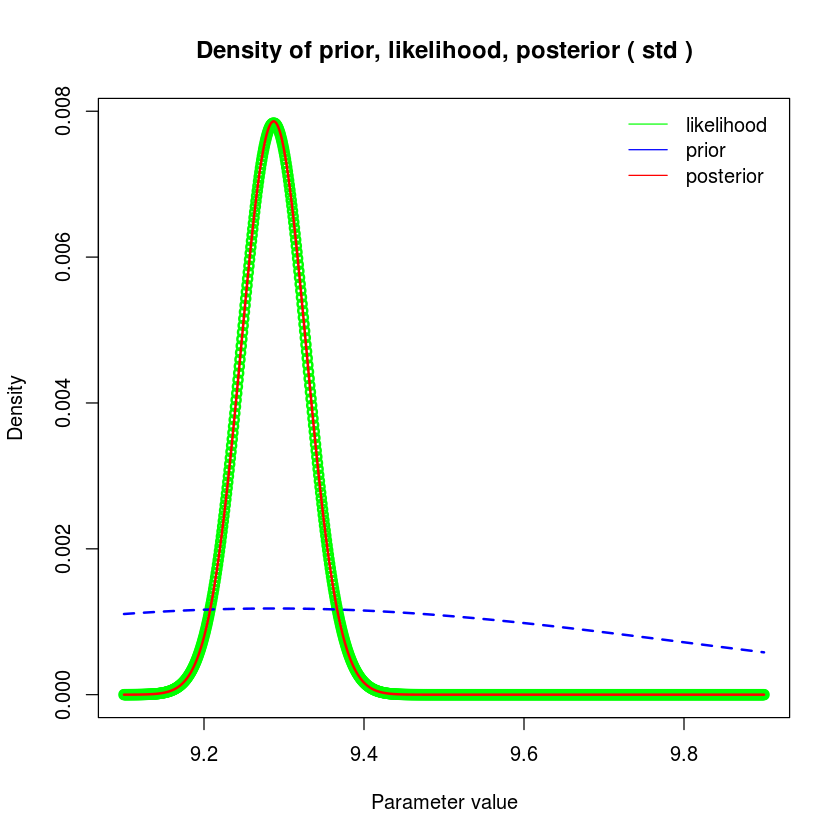

 Maximum of prior density = 9.626 
 Maximum likelihood = 9.626 
 MAP = 9.626

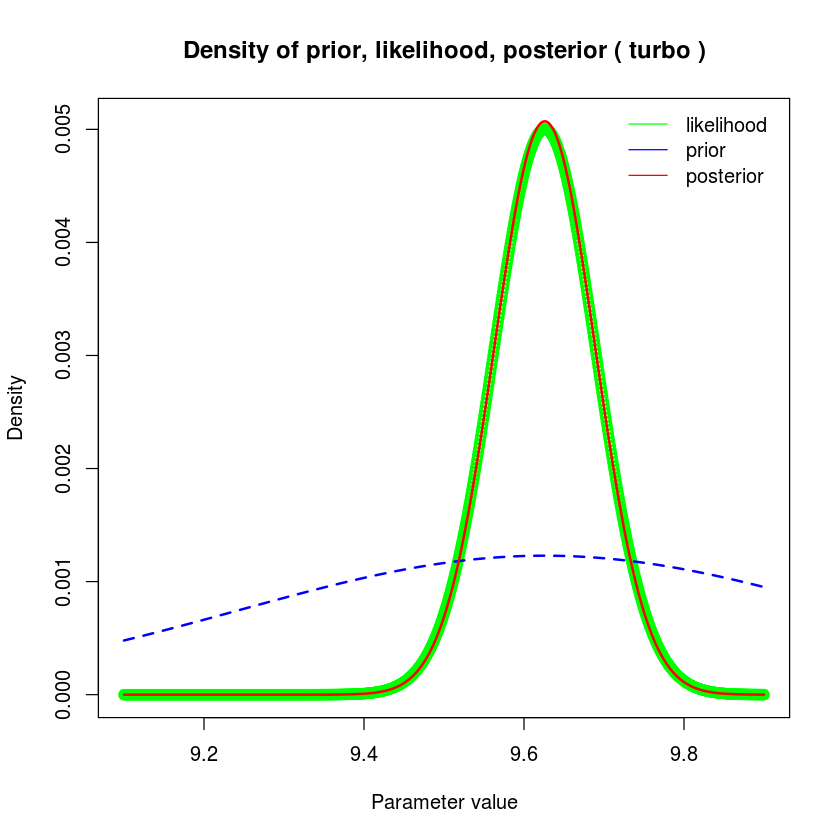

In [22]:
N = 1000 
start = 9.1
end = 9.9

post.autos.std = get.post(autos.std, start, end, N, title = "std")
post.autos.turbo = get.post(autos.turbo, start, end, N, title = "turbo")

The 0.95 Credible interval is 9.21 to 9.37

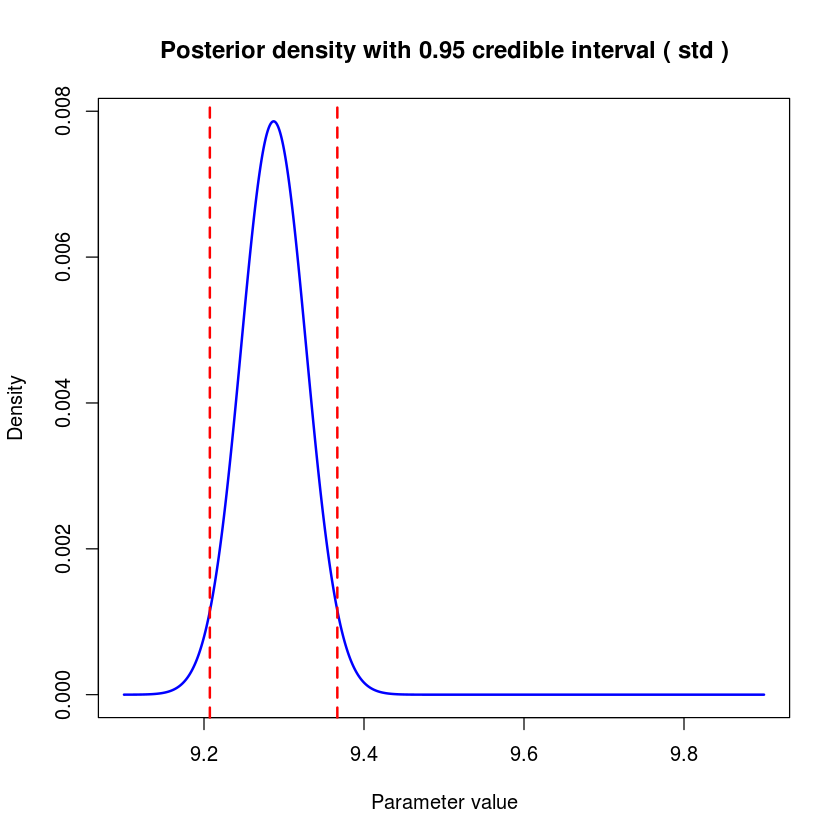

The 0.95 Credible interval is 9.5 to 9.75

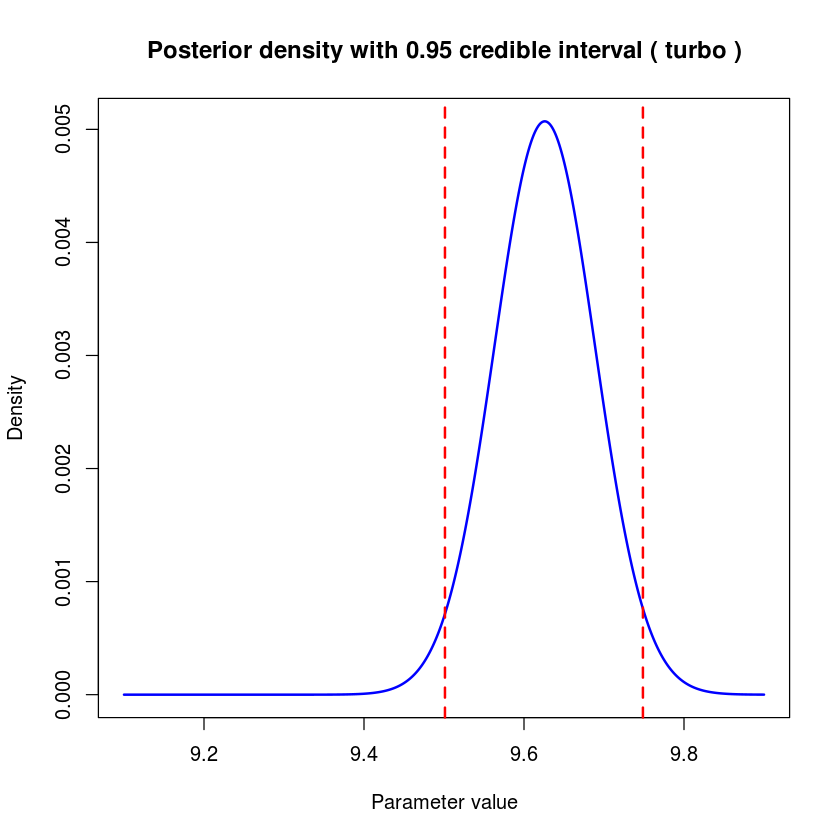

In [26]:
nSamps = 100000
qs = c(0.025, 0.975)
plot.ci(start, end, N, post.autos.std, nSamps, qs, "std")
plot.ci(start, end, N, post.autos.turbo, nSamps, qs, "turbo")

## Conclusions, Aspiration
- Credible intervals match confidence intervals very closely
  - Standard: [9.209-9.368] confidence; [9.21-9.37] credible
  - Turbo: [9.502-9.749] confidence; [9.5-9.75] credible

# Bayesian Estimate, Stratified by Fuel Type
Compare the difference of the Bayesian estimate of the mean of log of auto price stratified by 1) aspiration and 2) fuel type. Use both numerical and graphical methods for your comparison. 

- Are these means different within a 95% credible interval? 
- How do your conclusions compare to the results you obtained using the to the bootstrap resampled distribution of the mean and the t-test on the log price?
- Use a Normal(mean(sample), sigma(sample)) as your prior distribution for both exercises. 
- Use sigma(sample), the empirical value of the standard deviation, as a fixed parameter in your likelihood for both exercises.  

In [27]:
autos.gas = autos[autos$fuel.type == 'gas',]
autos.diesel = autos[autos$fuel.type == 'diesel',]

 Mean = 9.325876 Standard deviation = 0.5072395 
 Maximum of prior density = 9.326 
 Maximum likelihood = 9.326 
 MAP = 9.326 Mean = 9.55742 Standard deviation = 0.4880124 


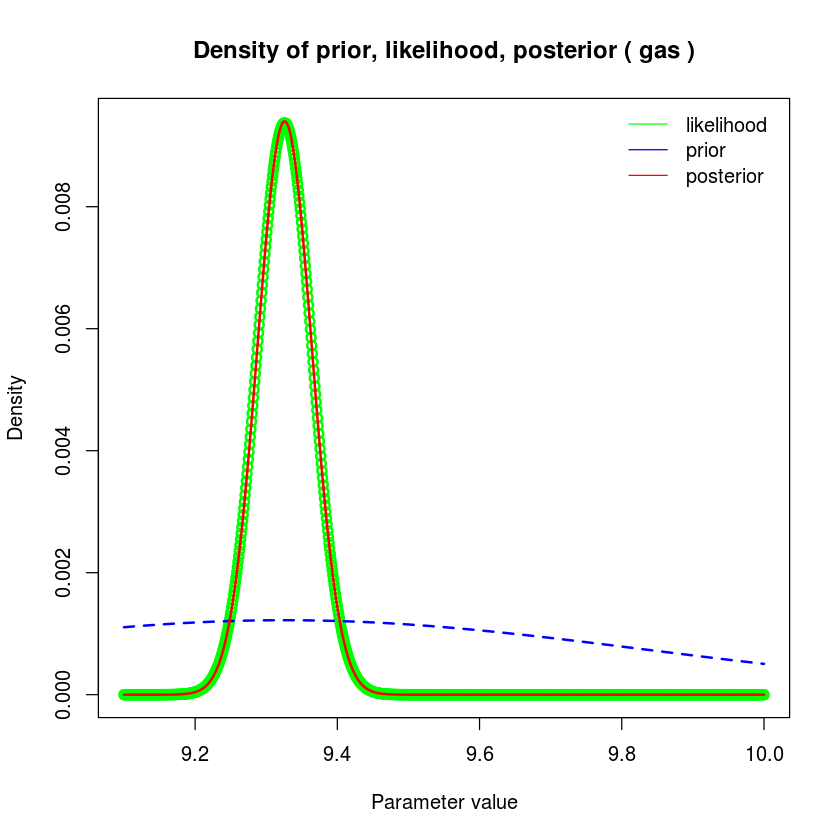

 Maximum of prior density = 9.558 
 Maximum likelihood = 9.558 
 MAP = 9.558

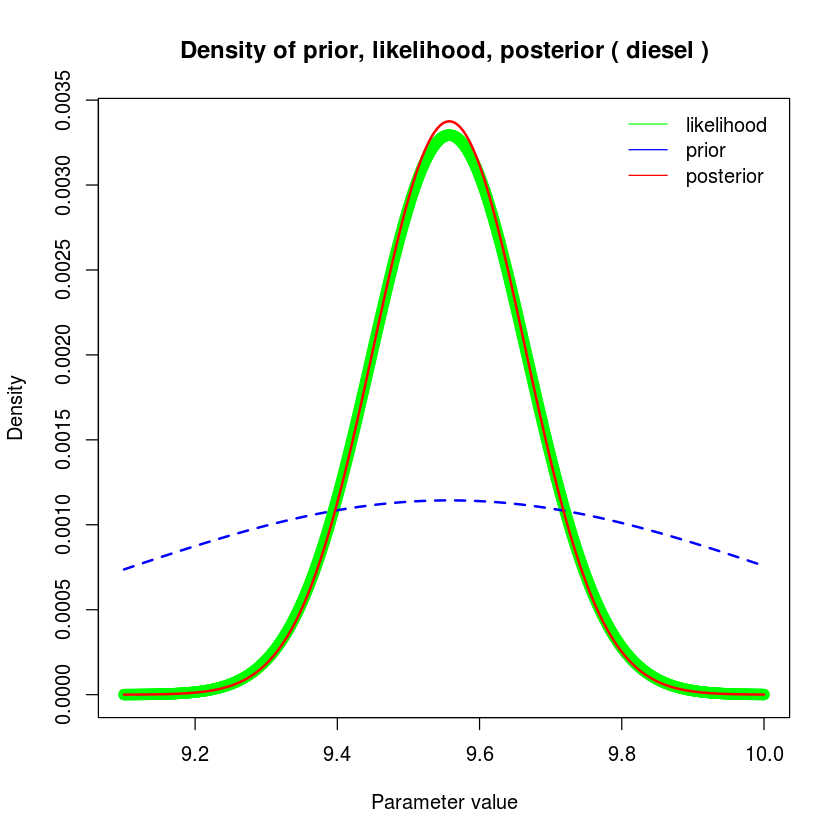

In [28]:
N = 1000 
start = 9.1
end = 10.0

post.autos.gas    = get.post(autos.gas,    start, end, N, title = "gas")
post.autos.diesel = get.post(autos.diesel, start, end, N, title = "diesel")

The 0.95 Credible interval is 9.25 to 9.4

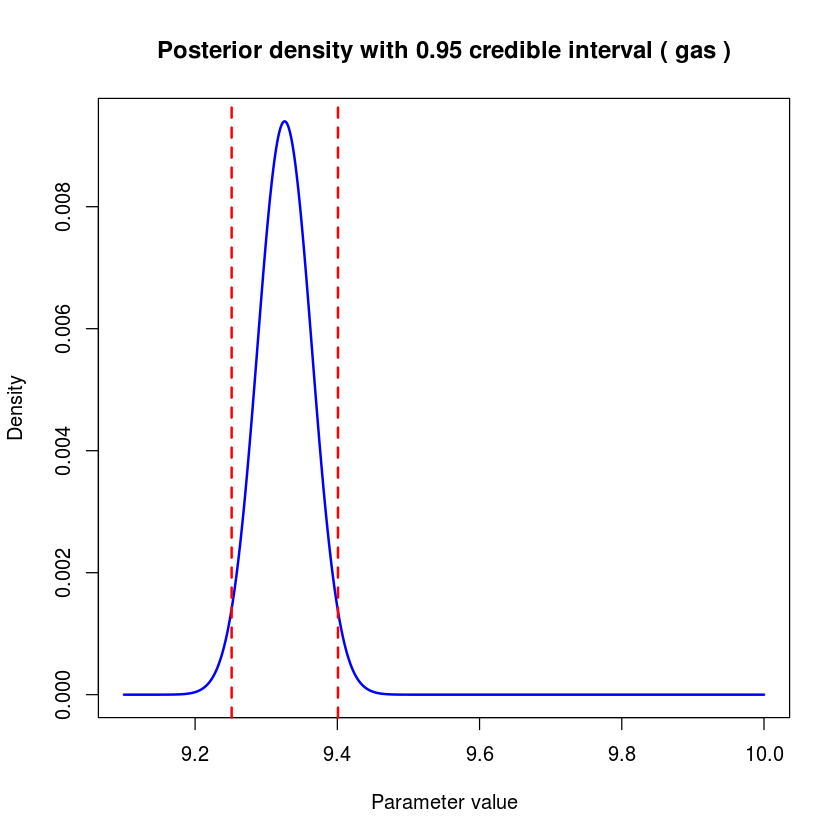

The 0.95 Credible interval is 9.35 to 9.77

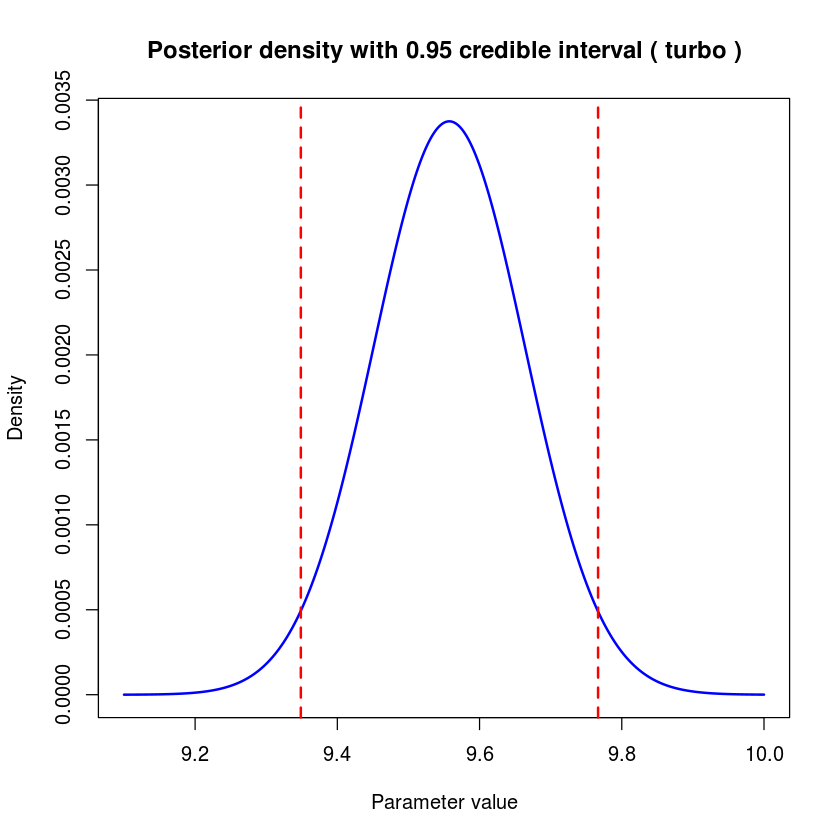

In [30]:
nSamps = 100000
qs = c(0.025, 0.975)
plot.ci(start, end, N, post.autos.gas,    nSamps, qs, "gas")
plot.ci(start, end, N, post.autos.diesel, nSamps, qs, "turbo")

## Conclusions, Fuel Type
- Credible intervals match confidence intervals very closely
  - Gas: [9.252-9.401] confidence; [9.25-9.4] credible
  - Diesel: [9.352-9.766] confidence; [9.35-9.76] credible

# Bayesian Estimate, Stratified by Body Style
- Compare the differences of the Bayesian estimate of the distribution of the log price of the autos grouped by body style. You will need to do this pair wise; e.g. between each possible pairing of body styles. Use both numerical and graphical methods for your comparison. 
- Which pairs of means are different within a 95% credible interval? 
- How do your conclusions compare to the results you obtained from the bootstrap method, ANOVA and Tukey’s HSD analysis you previously performed? 
- Notice that the posterior is closer to the likelihood for groups with more data values. 

- Use a Normal(mean(sample), sigma(sample)) as your prior distribution for both exercises. Use sigma(sample), the empirical value of the standard deviation, as a fixed parameter in your likelihood for both exercises.  

In [18]:
autos.sedan     = autos[autos$body.style == 'sedan',]
autos.hatchback = autos[autos$body.style == 'hatchback',]
autos.wagon     = autos[autos$body.style == 'wagon',]

In [19]:
N = 1000 
start = 8.8
end = 9.8

post.autos.sedan = get.post(autos.sedan, start, end, N, title = "sedan")
post.autos.hatchback = get.post(autos.hatchback, start, end, N, title = "hatchback")
post.autos.wagon = get.post(autos.wagon, start, end, N, title = "wagon")

 Mean = 9.438602 Standard deviation = 0.5126516 


ERROR: Error in posterior(pp, like.autos): object 'pp' not found


In [ ]:
nSamps = 100000
qs = c(0.025, 0.975)
plot.ci(p, post.autos.sedan,     nSamps, qs, "sedan")
plot.ci(p, post.autos.hatchback, nSamps, qs, "hatchback")

plot.ci(p, post.autos.wagon,     nSamps, qs, "wagon")
plot.ci(p, post.autos.hatchback, nSamps, qs, "hatchback")

plot.ci(p, post.autos.wagon,     nSamps, qs, "wagon")
plot.ci(p, post.autos.sedan,     nSamps, qs, "sedan")

In [ ]:
## Conclusions, Body Style
